**Import Libraries**

In [76]:
from pytket import Circuit, Qubit, Bit, circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import numpy as np
import math
import sys

**Set print options for visualising and mappings later**



In [70]:
#Useful for printing and visualising matrices and mapping of incrementboxes for future

np.set_printoptions(suppress=True,linewidth=np.nan, threshold=sys.maxsize)

def print_unitary(c):
    print(np.around(np.array(c.get_unitary(), dtype='float'), 1))

def print_mapping(u):
    for i in range(u.shape[0]):
        for x in range(u.shape[1]):
            if u[x][i] == 1:
                print(f"{i} --> {x}")

**ModuloIncrementorBox and Benchmark**

A modulo increment is a permutation that satisfies:  

$C_{k}|j\rangle = |(j + k) \mod 2^{n\_qubits}\rangle$
<br>
<br>
$E.g.:$  <br>
$C_{3}|000\rangle = |011\rangle$  <br>
$C_{3}|101\rangle = |000\rangle$  <br> 
$Etc. for \space all \space states \space in \space the \space bases$

The original idea of applying a modulo increment by using the QFT (Quantum Fourier Transform) was given by Julien Sorci. The QFT approach uses around $2N^2$ two qubit gates, whereas the ToffoliBox uses around $2^N$ two qubit gates for N qubits. Benchmarked against ToffoliBox, we see a very clear increase in efficiency for uniform increments. However this approach only works for modulo increments, and not for any arbitrary permutation (as expected), therefore there are lots of limits to its applications:  
<br>
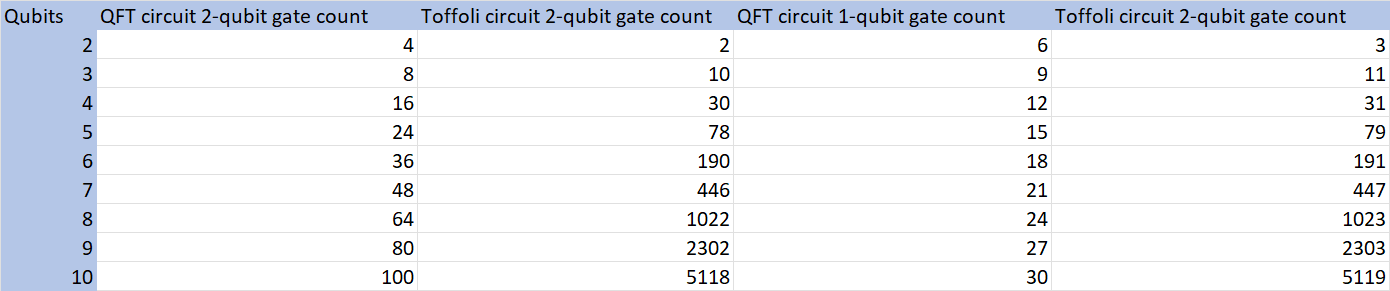  
<br>

**Modulo Increment of all States**

Given any arbitrary permutation M, we can diagonalise it into:  

$M = UDU^\dagger$,  

where $U$ is a unitary matrix with its columns being the eigenvectors of operator $M$, and $D$ a diagonal matrix with the eigenvalues of operator $M$, with $D_{ii} = i^{th}$ column of $U$. For any modulo increment $M_{c}$, we take advantage of the fact that the corresponding $U$ is always the $QFT$, with the roots of unity $\omega$ = $e^{\frac{i2\pi}{2^{n\_qubits}}}$. We can decompose the modulo increment into a $QFT$, an $QFT^\dagger$, and a diagonal matrix with $D_{ii} = \omega^{i-1}$  

By acting on all the qubits in this way, we can easily achieve a modulo increment of any increment through all the basis states:  

$C_{k}|j\rangle = |(j + k) \mod 2^{n\_qubits}\rangle$


<br>

**The Problem and High Level Intuition**

Given our "rudimentary" tool of being able to modulo increment any set of bases states with a given increment k, we would like to be able to make an algorithm that can take any (adjacent) sub-group of states ($n$) within a system, and increment it by a certain value, ($k \mod n$):  

$$
C_{n,k,start}|j\rangle
=
\begin{cases}
|j\rangle \text{\hspace{11.65cm}if} \ (j > start + n) \space or \space (j < start), \\
|[(j + k - start) \mod (n) + start] \mod 2^{n\_qubits}\rangle \text{\hspace{3cm}if} \space start \le j \le start+n\\
\end{cases}
$$

**Modulo Increment of Arbitrary Chunk Size $2^x$ States**

We will describe a modulo increment of size $2^x$ (where $x$ is an arbitrary number, given $x \le  n\_qubits$), as $C_{n, k}$ where $n$ is the number of states being permutated, and k is the increment:  

$$
C_{n,k}|j\rangle
=
\begin{cases}
|j\rangle \text{\hspace{5.65cm}if} \ 0 \le j < n, \\
|j + (k \mod n)\rangle \text{\hspace{3cm}if} \space j \ge n\\
\end{cases}
$$

When modulo incrementing only a section of the states, the other states are left in their original position, e.g $C_{4, 3}$ for 3 qubits:

<div>
    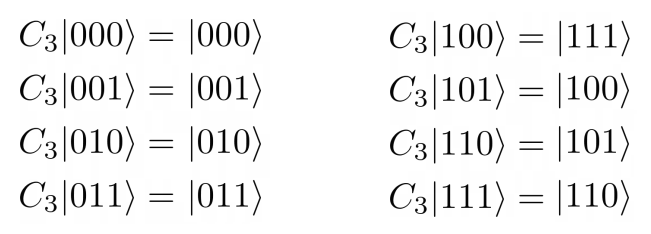
</div>  

This can be done easily by using most significant bits (MSBs) as control qubits to control a modulo increment of all states (in the above box) on only the remaining qubits. To gain intuition, we take the above example $C_{4, 3}$ for 3 qubits. We can see that it permutates half of the states, and leaves the others stationary. By assigning the most significant bit (MSB) as a control qubit, a modulo increment will only act on the 2 other qubits when the MSB is in state 1, which is for half the states. To only permutate the last 2 states, we can half the number of states we are permutating again by taking the second MSB as a control too, and only modulo increment the last 2 states (in this case is the same as a transposition). We can now see easily that to achieve a modulo increment on only $n$ number of states, we use: $Q_{controls} = N\_qubits - \log_2{(n)}$ MSB qubits as controls.

**Starting from any Position by Conjugation**

We are now able to permutate a section of size $2^x$ of a set of states by using the QFT and assigning qubits as controls to modulo increment the remaining qubits. To modulo increment any section of size $2^x$ starting from any position within the states:  

$$
C_{n,k,start}|j\rangle
=
\begin{cases}
|j\rangle \text{\hspace{11.65cm}if} \ (j > start + n) \space or \space (j < start), \\
|[(j + k - start) \mod (n) + start] \mod 2^{n\_qubits}\rangle \text{\hspace{3cm}if} \space start \le j \le start+n\\
\end{cases}
$$

(where $n$ is a power of two) we can do so by conjugating the modulo increment. To do so, we apply:

$C^{-1} P C$  
<br>
where $C$ is a modulo increment of all the states, and $P$ is the modulo increment of a sub-section of all the states. Intuitively, we are shifting everything out of position first, then carry out the sub-section permutation, so that when we shift the sub-section to the area we want, the states we want left alone shift back to their original position untouched. We can notate this in the following way: $C_{n, k, start}$ where n is the size of the sub-section, k is the increment and start is the starting state the permutation is applied to.
For example for a 3-qubit system:  

$C_{4,3,1} = C_{8,3,0} \cdot C_{4,3,4} \cdot C_{8,5,0} \hspace{5cm}$

We can then find the equation $k = 2^{n\_qubits} - n - start$ for the first shift ($C^{-1}$), and to move everything back into position, $k = n + start$ for the final ($C$)

This means that now we are able to achieve a modulo increment of any sub-section of any length $2^x$ starting from any position within the states

This is implemented as the add_increment() function of the class ModuloIncrementorBox

**Modulo Increment of any sub-section of any length $x$ starting from any position within the states**

In add_increment(), the way of controlling the size of the sub-section was to use qubits of the circuit as controls for the rest of the qubits to modulo increment. This put a lot of limitations on the length of sub-section possible (only lengths of powers of two). To achieve increments of length that are not powers of two, we have to 'combine' increment boxes of length that are powers of two together. This achieves our final permutation goal that satisfies:  

$$
C_{n,k,start}|j\rangle
=
\begin{cases}
|j\rangle \text{\hspace{11.65cm}if} \ (j > start + n) \space or \space (j < start), \\
|[(j + k - start) \mod (n) + start] \mod 2^{n\_qubits}\rangle \text{\hspace{3cm}if} \space start \le j \le start+n\\
\end{cases}
$$

To have a better understanding of this method, it's important to introduce a simple but very effective notation of describing permutations. This notation draws arrows to map what each state goes to, and by chaining together multiple diagrams, we can effectively read off the overall permutation. For $C_{8, 2, 0}$ for a 3 qubit system (no shift required):
<center>
    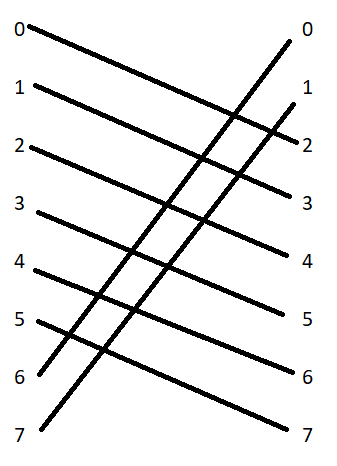
<center>  

For a modulo increment of length 15 for a 5 qubit system, $C_{15,3, 0}$:
<center>
    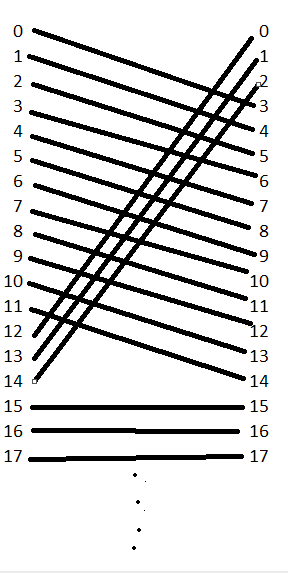
</center>  

We will try to break down the above permutation into combinations of smaller modulo increments of size $2^x$. If we let $L$ be the number of states still out of position (15 for this case at the start), the goal is to recursively reduce $L$ by placing states in their final positions until $L = 0$, where all states are in their desired positions after the overall permutation. Initially, it looks like recursively adding the modulo increment:  

$C_{2^m, 3, (L - 1) - 2^m}$  

where $2^m < L < 2^{m+1}$ for each iteration (the largest power of two that can fit within $L$), and $L_{n+1} = L_{n} - (2^m - k)$ for iteration $n$, would give us $C_{15, 3, 0}$. If we carry out the iteration one by one:  

<center>
    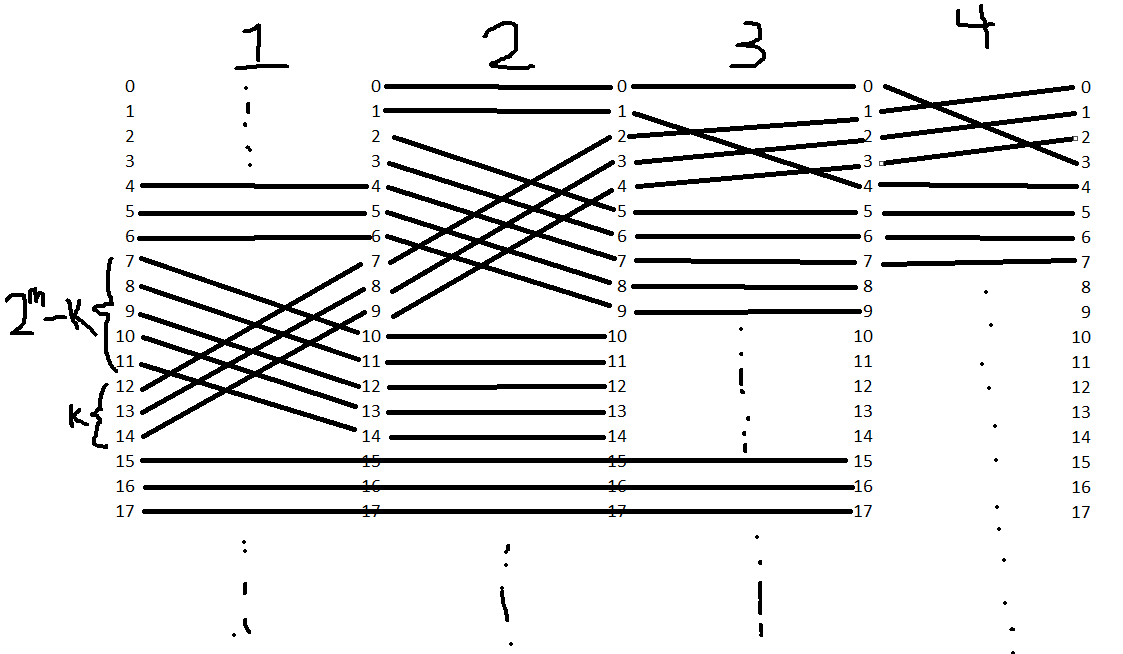
</center>  

we get numerous useful results from this. First, we can read off straight away what the equation for each iterating $L$ is. Intuitively, each iteration, we are placing $2^m - k$ states in their correct position, and shifting our "$k$s" towards the "top right corner" where it is supposed to end up, dragging it each iteration so they (the "$k$s") doesn't get lost. We also see that after the fourth iteration everything is now in the correct position, and so we can break from the loop. It seems that this algorithm works, but I will now show you a scenario where an error occurs.  

Consider the example, for a 5 qubit system, $C_{9,4,0}$. We will again try to iterate through our algorithm:

<center>
    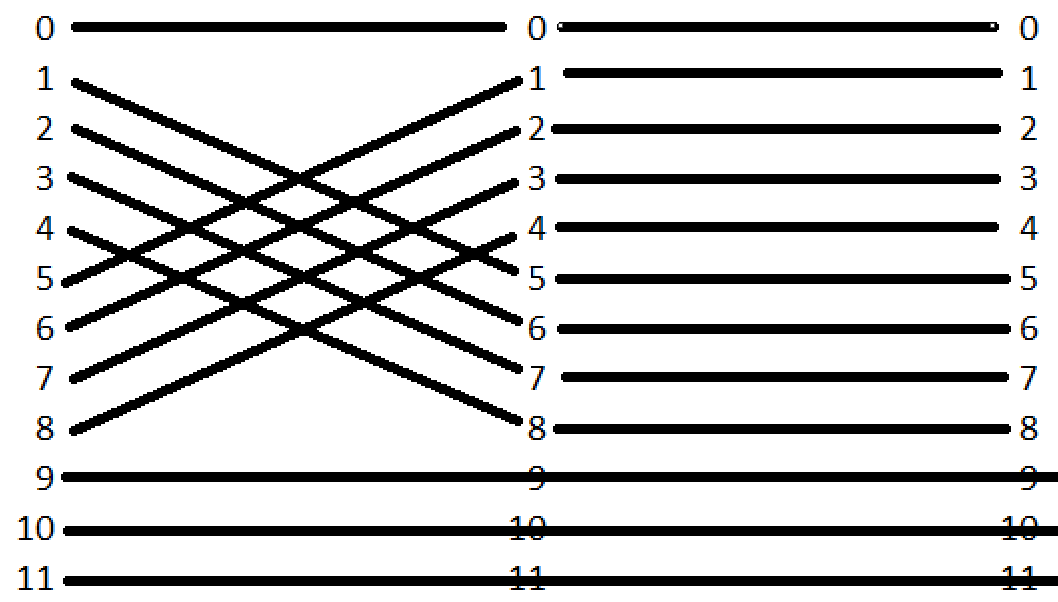
</center>  

We see that it has now gotten 'stuck' in a wrong position, where $2^m = k$, meaning that it applies nothing to the sub-section (basis states 1-4) which are still out of position as $C_{k,k,0} = 0$. Another example for the same system, iterating through our algorithm for $C_{9,5,0}$:  

<center>
    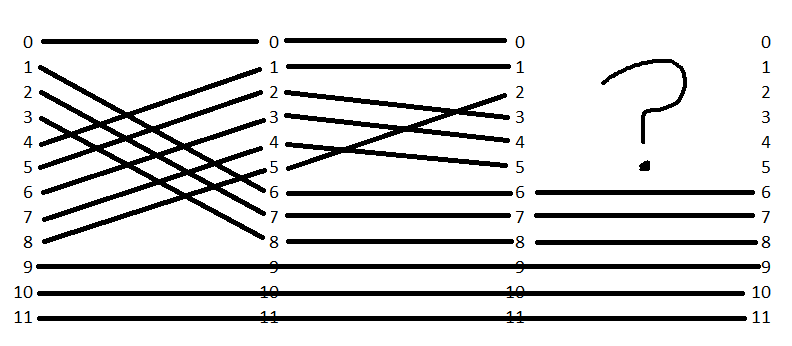
</center>  

In this example, eventually $k > 2^m$, meaning that the modulo increment applied is no longer of increment $k$, but of increment $k\mod2^m$, resulting in a muddled permutation that places states in the wrong position. We can now see that the algorithm breaks when we reach the case $k \ge 2^m$. Attempting to continue applying the same algorithm after it breaks would only muddle up the permutation even further from the desired result and iterates for an infinite time.  

However, to fix this, when we reach the case where our algorithm would break down, we can reverse the "direction" of where the "$k$s" are going, and where the states are being placed in the correct position. To do this, we have a up boolean variable that when true, states that the "$k$s" are being placed upwards, and states and being placed in their correct finishing positions downwards. When $k >= 2^m$, we swap "direction" from up to down, and find a new $k$, continuing the algorithm as before.  

Again looking at the diagram, we can interpret the new $k$ to be $-(L - \|{k}\|)$ as we are essentially shifting our "$k$s" to the very "corner" (top right for up, and bottom right for down) of our states. When we reach the case where our algorithm breaks down, we want to essentially shift our "$k$s" up (or down) by whatever remaining block there is. For example, in the case above, the new $k$ will be $-1$, as we want to shift out "$k$s" up by one:  

<center>
    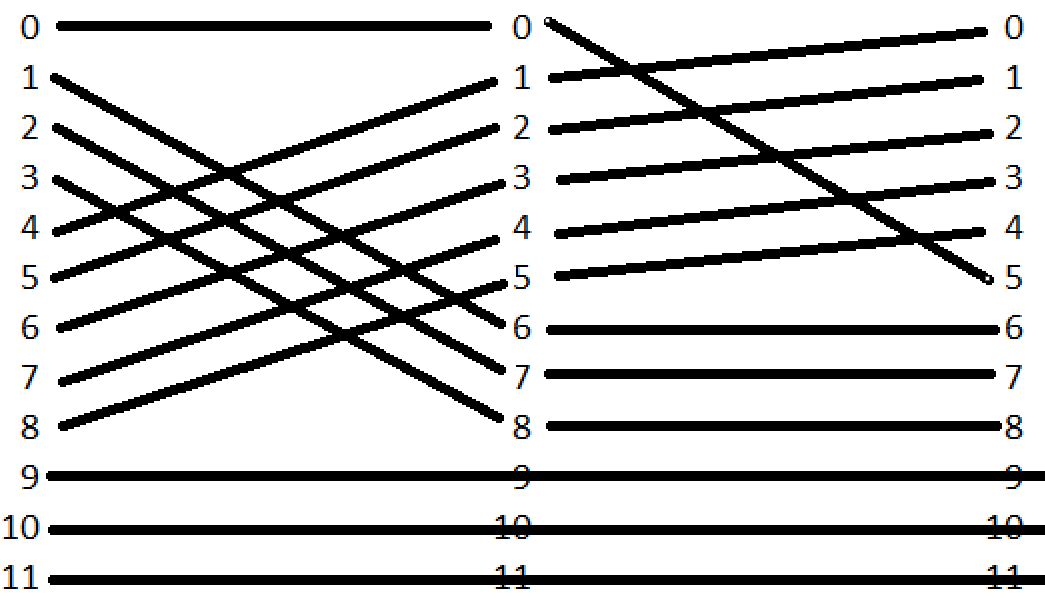
</center>  

This solves our problem which happens when the case breaks, and now our algorithm can implement a modulo increment of any length L, of any increment k, and starting from any position in our states. This can be better thought of as an algorithm that takes a set of bases states, and for each states adds an increment of $k \mod n$  

Here is a short pseudocode of the recursive algorithm:

<div>
    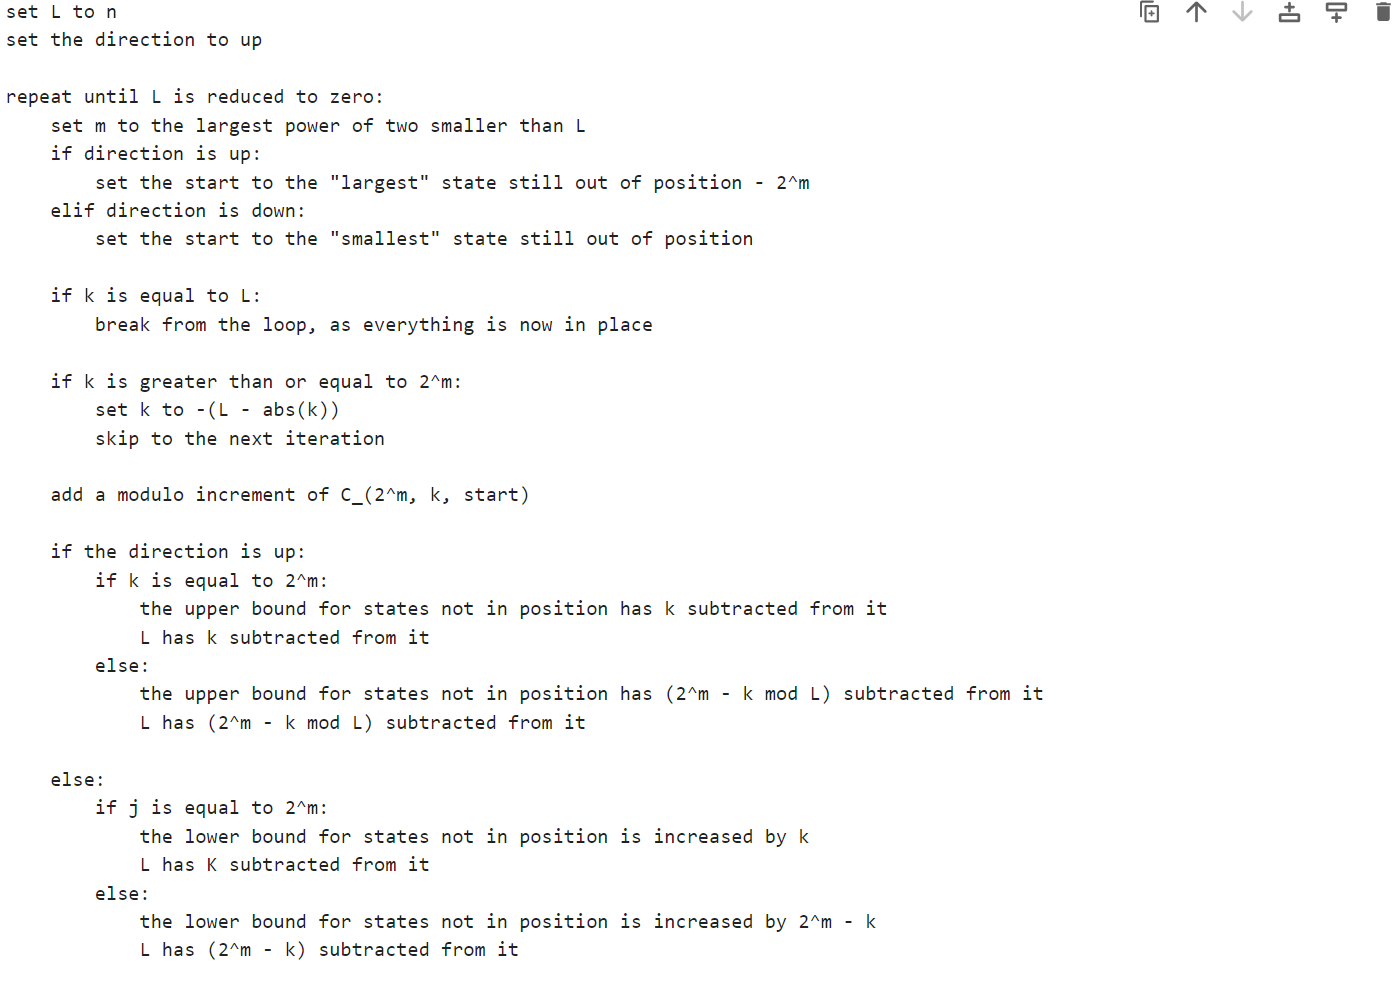
</div>  

**The CyclicBox class**

In [87]:
class ModuloIncrementorBox:
    def __init__(self, qubits: int):
        """Create the circuit for the modulo increment box"""
        
        self.main_c = Circuit(qubits, qubits)          #add bits for measurements if necessary in the future for testing
        self.dimension = qubits                        #set dimensions for the box

        return None

    
    def build_cyclic(self, controls: list, k: int, qubits: list):
        """Appends a modulo increment via the QFT approach to the circuit, with controls being the control qubits (if necessary) applied to the permuta
        tion box, k the increment on each state, and qubits the qubits where the modulo increment is being applied on in the circuit"""

        #This approach works because columns in the QFT are the eigenvectors of any modulo increment, meaning we can diagnolize the permutation
        
        self.scaffold_c = Circuit(len(qubits))           #Create a scaffolding circuit
        
        self.scaffold_c.append(self.buildfourier(len(qubits)))               #Adding the modulo increment to the circuit by appling a QFT
        self.scaffold_c.append(self.builddeltak(len(qubits), k))             #on the qubits, then a diagonal matrix with eigenvalues of the  
        self.scaffold_c.append(self.buildinversefourier(len(qubits)))        #matrix of the modulo increment, and then applying the inverse QFT
        
        self.boxed_scaffoldc = circuit.CircBox(self.scaffold_c)                                #Creating the scaffold box and control box if necessary
        self.cboxed_scaffoldc = circuit.QControlBox(self.boxed_scaffoldc, len(controls))
        
        self.main_c.add_qcontrolbox(self.cboxed_scaffoldc, controls+qubits)     #Adding the scaffold box with the modulo increment to the main circuit
        
        return True

        
    def buildfourier(self, n):
        """Returns a QFT for n qubits as a circuit"""
        
        scaffold_f = Circuit(n)    #Create a scaffolding circuit     
        
        for qubit in range(n): 
            scaffold_f.H(qubit)                                   #Create a QFT as described in Nielsen & Chuang Fig 5.1, by iterating through each qubit
            for i in range(n - 1 - qubit):                        #and adding the Hadamard gate and single rotation gates
                scaffold_f.add_gate(OpType.CU1, float(2 / 2**(i+2)), [qubit + i + 1, qubit])
        
        for qubit in range(n//2):                 #Reverse the qubits, as the QFT reverses the qubits
            scaffold_f.SWAP(qubit, n - 1 - qubit)

        return scaffold_f

    
    def buildinversefourier(self, n):
        """Returns an inverse QFT for n qubits as a circuit"""
        
        scaffold_if = Circuit(n)
                                                           #Reverse of QFT 
        for qubit in range(n//2):
            scaffold_if.SWAP(qubit, n - 1 - qubit)

        for qubit in reversed(range(n)):
            for i in reversed(range(n - 1 - qubit)):
                scaffold_if.add_gate(OpType.CU1, float(-2 / 2**(i+2)), [qubit + i + 1, qubit])
            
            scaffold_if.H(qubit)
            
        return scaffold_if

    
    def builddeltak(self, n, k):
        """Returns the diagonal matrix of eigenvalues of the permutation with n qubits and increment of k"""
        
        scaffold_dk = Circuit(n)    #Create the scaffold circuit
        
        for qubit in range(n):                                                               #Makes the operator that applies the diagonal matrix as 
            scaffold_dk.U1(float((2 * k * (2 ** (n - qubit - 1))) / (2 ** n)), qubit)        #a tensor product of single rotation gates on each qubit

        return scaffold_dk

    
    def add_increment(self, n : int, k : int, start = -1):
        """Append a modulo increment to the circuit starting from any position (shift = False, if it goes to the end), where n is the length
        of the permutation (must be a power of 2, e.g. 2^x), start is the starting 'bit' in binary form (can be left for no shift), given in 
        integer form, and k is the increment"""
        
        if start != -1:                            #If a shift is necessary, 'shift' the permutation by conjugating the modulo increment with another one
            n_controls = self.dimension - int(math.log(n, 2))     #Set the number of control qubits necessary to achieve the length of the permutation
            shift = 2 ** self.dimension - n - start        #Set the shift to make the modulo increment start from the chosen value
    
            self.build_cyclic(controls=[], k=shift, qubits=[i for i in range(self.dimension)])         #Append the modulo increment to the circuit
            self.build_cyclic(controls=[i for i in range(n_controls)], k=k, qubits=[i for i in range(self.dimension) if i not in [z for z in range(n_controls)]])
            self.build_cyclic(controls=[], k=2**self.dimension-shift, qubits=[i for i in range(self.dimension)])
            
        else:                               #If a shift is not required, add the modulo increment directly to the circuit
            
            n_controls = self.dimension - int(math.log(n, 2))       #Set the number of control qubits necessary to achieve the length of the permutation
            self.build_cyclic(controls=[i for i in range(n_controls)], k=k, qubits=[i for i in range(self.dimension) if i not in [z for z in range(n_controls)]])

        return True

    
    def add_lengthed_increment(self, n: int, k : int, start = -1):
        """Adds a modulo increment of any length starting from any position to the circuit, where n is the length, k is the increment, and start
        is the starting 'bit' in binary form (can be left for no shift), given in integer form"""
        
        L = n             #Length of permutation, also used as remaining states to be put in their correct finishing position
        k = k             #Increment k, as in all other uniform increments
        up = True         #The direction is up, the use will become clear later
        
        if start == -1:                 #If a shift is needed, apply the shift
            placed = [-1, int(L)]       #Values between (non-inclusive) the values in placed are yet to be in the correct position, we use this to change
        else:                           #direction later
            placed = [start - 1, start + int(L)]

        while L > 1:                 #Recursively carry out smaller uniform increments until all states are put in their correct position
            m = int(math.log(L, 2))       #work out m, by the equation: 2^m <= L < 2^(m+1). Taking int of the float automatically truncates it (floor)
        
            if up:                                #Assign the starting position of the sub modulo increment according to the direction
                start = placed[1] - 2 ** m
            else:
                start = placed[0] + 1
                
            if abs(k) == L:              #Everything is now in position, break from the loop
                break
                
            if k >= 2**m:                       #When the algorithm break down (when k >= 2**m), reverse the direction, and assign the new k necessary to
                k = -(L - abs(k))               #continue the sub uniform increments that achieves the same k in the overall modulo increment. Also 
                continue                  #Skip the broken case, and carry on to the new fixed one
        
            self.add_increment(2**m, k, start)      #Add the sub modulo increment
            
            if up:                                          #Assign the new remaining states still needing to be cyclicly permutated on based on the 
                if 2**m == k:                               #direction and remaining k. Also fixes the special case where 2**m == k, by correcting the 
                    placed[1] -= k                          #L to account for this
                    L -= k
                else:
                    placed[1] -= (2 ** m - (k % L))
                    L -= 2 ** m - (k % L)
            else:
                if 2**m == k:
                    placed[0] += abs(k)
                    L -= k
                else:
                    placed[0] += 2 ** m - abs(k)
                    L -= 2 ** m - abs(k)

        return True

In [86]:
length = 15        #Set the parameters for the modulo increment, and visualise the circuit and mapping
k = 3
start = 3

Permutator = ModuloIncrementorBox(5)
Permutator.add_lengthed_increment(length, k, start)
render_circuit_jupyter(Permutator.main_c)
print_mapping(np.around(np.array(Permutator.main_c.get_unitary(), dtype='int'), 1))   #Will always give a ComplexWarning, can ignore
print_unitary(Permutator.main_c)                  #Will also always give a ComplexWarning, and can again, ignore 

0 --> 0
1 --> 1
2 --> 2
3 --> 6
4 --> 7
5 --> 8
6 --> 9
7 --> 10
8 --> 11
9 --> 12
10 --> 13
11 --> 14
12 --> 15
13 --> 16
14 --> 17
15 --> 3
16 --> 4
17 --> 5
18 --> 18
19 --> 19
20 --> 20
21 --> 21
22 --> 22
23 --> 23
24 --> 24
25 --> 25
26 --> 26
27 --> 27
28 --> 28
29 --> 29
30 --> 30
31 --> 31
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

C:\Users\Jack.Fan\AppData\Local\Temp\ipykernel_4548\480098707.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  print_mapping(np.around(np.array(Permutator.main_c.get_unitary(), dtype='int'), 1))   #Will always give a ComplexWarning, can ignore
C:\Users\Jack.Fan\AppData\Local\Temp\ipykernel_4548\647725039.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.around(np.array(c.get_unitary(), dtype='float'), 1))
